# Model Insights

This is notebook 5 (out of 5) for <b>Project 3</b> of the GA Data Science Immersive<br>
Notebook by: <b>Martijn de Vries</b><br>
martijndevries91@gmail.com

## In this Notebook

I will load in the best models from the modeling notebook that I pickled. I will do some interpretation regarding which features are the most predictive, and look at the final accuracy score vs the baseline.

Just as in the previous notebooks, I'll start with the post Titles model, then move on to the commments model

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re

#custom
from custom_funcs import Tfidf_BigramReducer, my_preprocessor

#sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


## 1) Title model: insights

Let's start by re-loading the data, and the stacked model that I pickled in the modeling notebook. 

Sidenote: I put the custom transformer Tfidf_BigramReducer and the my_preprocessor function in a .py file so that I can just import them (see imports above) without having to copy-paste them here.

In [2]:
post_df = pd.read_csv('../data/all_submissions_cleaned.csv')

post_df['subreddit'] = post_df['subreddit'].map({'conservative':0, 'politics':1})

X = post_df[['title', 'num_comments', 'domain']]
y = post_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
with open('../pickled_models/stacked_model_submissions.pkl', 'rb') as pickle_in:
    stacked_model_subs = pickle.load(pickle_in)

In [4]:
stacked_model_subs

StackingClassifier(estimators=[('m1',
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('tfbg',
                                                                                  Tfidf_BigramReducer(bf=0.1,
                                                                                                      max_features=30000,
                                                                                                      preprocessor=<function my_preprocessor at 0x7f8bf3ae6040>,
                                                                                                      stop_words='english'),
                                                                                  'title'),
                                                                                 ('ss',
                                                                                  StandardScaler(),
                                                                                  ['num_comments']),
                                                                                 ('ohe',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['domain'])])),
                                                ('lr',
                                                 Lo...
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('tfbg',
                                                                                  Tfidf_BigramReducer(bf=0.1,
                                                                                                      max_features=40000,
                                                                                                      preprocessor=<function my_preprocessor at 0x7f8bf3ae6040>,
                                                                                                      stop_words='english'),
                                                                                  'title'),
                                                                                 ('mm',
                                                                                  MinMaxScaler(),
                                                                                  ['num_comments']),
                                                                                 ('ohe',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['domain'])])),
                                                ('nb', MultinomialNB())]))],
                   final_estimator=LogisticRegression())

Although the stacked model in itself may not be that interpretable, the individual models that make up our StackingClassifier all have some degree of interpretability:
1) for Logistic Regression, each feature has coefficients that return the log odds of a certain feature changing the odds towards or away from class 1
2) Random Forest returns a list of feature importances
3) Multinomial NB returns a list of log probabilities for each class, that that feature is part of an entry of that class <br>

Which of the models was weighed the most by the final estimator?

In [5]:
models = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
final_coefs = stacked_model_subs.final_estimator_.coef_[0]
for i in range(3):
    print(f'{models[i]} weight: {round(final_coefs[i],3)}')

Logistic Regression weight: 0.746
Random Forest weight: 5.662
Naive Bayes weight: 1.94


### 1.1) Random Forest interpretation

Above, we can see that the model that is weighted the most in the stacked model is the Random Forest classifier. For that specific model, we can get a list of feature importances to figure out which features the model thought were the most important. In order to access the attributes of the Random Forest Classifier, we need to call the named_estimators_ attribute of the stacked model and select model 2. As each base model is a Pipeline object in itself, we then need to access the random forest with the named_steps attribute and use the alias we specified for the random forest (rf).

In [6]:
rf_in_stack = stacked_model_subs.named_estimators_.m2.named_steps.rf
rf_importances = rf_in_stack.feature_importances_
ct2_in_stack = stacked_model_subs.named_estimators_.m2.named_steps.ct
rf_feature_names = ct2_in_stack.get_feature_names_out()

In [7]:
zipped_f = zip(rf_feature_names, rf_importances)
sorted_f = sorted(zipped_f, key= lambda x: x[1], reverse=True)[:500]

hi_mono_names, hi_bi_names = [], []
hi_mono_imp, hi_bi_imp = [], []

for feature in sorted_f:
    if 'tfbg' in feature[0]:
        if len(feature[0].split(' ')) == 1:
            hi_mono_names.append(feature[0][6:])
            hi_mono_imp.append(feature[1])
        if len(feature[0].split(' ')) == 2:
            hi_bi_names.append(feature[0][6:])
            hi_bi_imp.append(feature[1])

According to the random forest classifier, The additional features 'domain' and num_comments' help the most with classification:

In [8]:
sorted_f[:20]

[('ss__num_comments', 0.13504547947870602),
 ('ohe__domain_reddit', 0.021788010391990447),
 ('ohe__domain_image', 0.01865944191020541),
 ('tfbg__trump', 0.01256331212122673),
 ('ohe__domain_breitbart', 0.011811011210621633),
 ('ohe__domain_foxnews', 0.010183111754516814),
 ('ohe__domain_tampafp', 0.009680137580473275),
 ('ohe__domain_none', 0.00958368723814532),
 ('ohe__domain_nypost', 0.009103336976758216),
 ('ohe__domain_washingtonpost', 0.008131078008063192),
 ('ohe__domain_cnn', 0.007861549479325752),
 ('ohe__domain_thehill', 0.0074885574957576),
 ('ohe__domain_nytimes', 0.007053461086324851),
 ('ohe__domain_redstate', 0.0070488011878285005),
 ('ohe__domain_other', 0.006803747182445233),
 ('ohe__domain_politico', 0.005494617110135774),
 ('tfbg__biden', 0.0045070407840302334),
 ('ohe__domain_huffpost', 0.0042669915513446335),
 ('ohe__domain_youtube', 0.004218938333132806),
 ('ohe__domain_theguardian', 0.004169192498097183)]

One thing that is not directly obvious from these feature importances is the <i>direction</i>. In other words, does the word 'trump' being mentioned more often imply that the post is more likely to come from r/politics, or from r/conservative?
One way to figure out the direction would be to simply calculate the pearson r coefficient between the feature and the subreddit. I got that idea from stackoverflow, here:
https://stackoverflow.com/questions/58314707/how-to-distinguish-the-direction-of-important-features-from-xgboost-or-random-fo

In [9]:
def calc_pearson_r_feature(feature_list, X_trans, y_train):
    """
    Input a list of features and the training data (transformed, for X)
    Outputs a list for each fea
    """
    dir_list = [] #list with feature direction
    for feature in feature_list:
        ind = np.where('tfbg__' + feature == rf_feature_names)[0][0]
        yl = y_train.shape[0]
        X_col = X_trans[:,ind].todense().reshape(yl)
        p_r = np.corrcoef(X_col, y_train)[0,1]
        if p_r <= 0: 
            #A negative coefficient means more towards zero (= r/conservative)
            dir_list.append(0)
        elif p_r > 0:
            dir_list.append(1)
    return dir_list

In [10]:
#transform the training data again to access tfidf columns
X_tr = ct2_in_stack.fit_transform(X_train)
dir_list_mono = calc_pearson_r_feature(hi_mono_names, X_tr, y_train)
dir_list_bi = calc_pearson_r_feature(hi_bi_names, X_tr, y_train)

Now let's make a barplot of the monograms and bigrams with the most relative importance. I'll color-code each entry red or blue, depending on whether the occurence of the feature means the post is more likely to be from r/conservative or from r/politics, respectively.

In [11]:
def make_barplot(ax, wl, values, labels, directions):
    yl = np.arange(wl)
    clr = ['tab:red' if x <= 0 else 'tab:blue' for x in directions[:wl]]
    ax.barh(yl, values[:wl], color=clr)
    ax.set_yticks(yl)
    ax.set_yticklabels(labels=labels[:wl], fontsize=12)
    ax.invert_yaxis()
    ax.set_xlabel('Relative weight', fontsize=12)
    
    return

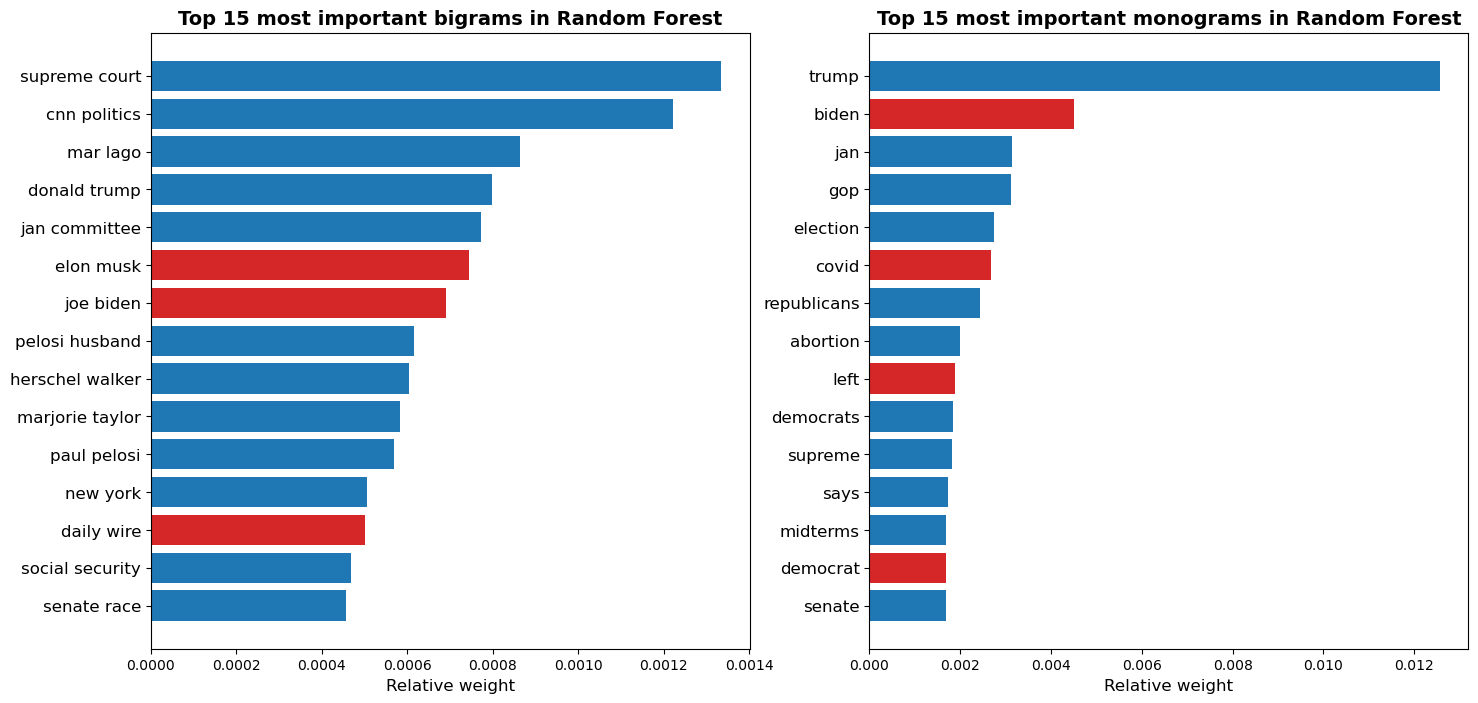

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

make_barplot(ax2, 15, hi_mono_imp, hi_mono_names, dir_list_mono)
make_barplot(ax1, 15, hi_bi_imp, hi_bi_names, dir_list_bi)

ax1.set_title('Top 15 most important bigrams in Random Forest', fontweight='bold', fontsize=14)
ax2.set_title('Top 15 most important monograms in Random Forest', fontweight='bold', fontsize=14)

plt.show()

### 1.2) Logistic Regression Interpretation

Let's look at the coefficients of the logistic regression model. We can access the attributes we want in a similar manner as for the random forest

In [69]:
lr_in_stack = stacked_model_subs.named_estimators_.m1.named_steps.lr
lr_coefs = lr_in_stack.coef_[0]
ct1_in_stack = stacked_model_subs.named_estimators_.m1.named_steps.ct
lr_feature_names = ct1_in_stack.get_feature_names_out()

Now let's do a similar thing as for the random forest classifier - we sort the coefficients (by absolute value, we care about high values both positive and negative), and then get the most important tfbg related columns.

In [70]:
zipped_lr = zip(lr_feature_names, lr_coefs)
sorted_lr = sorted(zipped_lr, key= lambda x: np.abs(x[1]), reverse=True)[:500]

In [71]:
sorted_lr[:20]

[('ohe__domain_image', -4.135640636674763),
 ('ohe__domain_tampafp', -3.7595375368243533),
 ('ohe__domain_redstate', -3.54714835231733),
 ('ohe__domain_breitbart', -3.4226139814947807),
 ('ohe__domain_hotair', -3.2138321994833077),
 ('tfbg__trump', 3.062362714528558),
 ('ohe__domain_thefederalist', -3.0159722594571),
 ('ohe__domain_amgreatness', -2.998875507629035),
 ('ohe__domain_theblaze', -2.9873233155942103),
 ('ohe__domain_nytimes', 2.932081693632392),
 ('ohe__domain_pjmedia', -2.892851189389558),
 ('ohe__domain_notthebee', -2.8558322872659962),
 ('ohe__domain_newsmax', -2.851534625342928),
 ('ohe__domain_huffpost', 2.8105740424528722),
 ('ohe__domain_townhall', -2.770039825255719),
 ('ohe__domain_reddit', -2.68927616883416),
 ('ohe__domain_timcast', -2.6861071231818205),
 ('ohe__domain_babylonbee', -2.6645746717925625),
 ('ohe__domain_commondreams', 2.6104210128068672),
 ('ohe__domain_justthenews', -2.56551620931431)]

Again, it's clear the domain features carried a lot of predictive power!

In [72]:
hi_mono_names, hi_bi_names = [], []
hi_mono_imp, hi_bi_imp = [], []

for feature in sorted_lr:
    if 'tfbg' in feature[0]:
        if len(feature[0].split(' ')) == 1:
            hi_mono_names.append(feature[0][6:])
            hi_mono_imp.append(feature[1])
        if len(feature[0].split(' ')) == 2:
            hi_bi_names.append(feature[0][6:])
            hi_bi_imp.append(feature[1])

We can again make a barplot of the most important monograms and bigrams. It is important to keep in mind that these coefficients measure something 

In [73]:
def make_barplot_lr(ax, wl, values, labels):
    yl = np.arange(wl)
    clr = ['tab:red' if x <= 0 else 'tab:blue' for x in values[:wl]]
    ax.barh(yl, values[:wl], color=clr)
    ax.set_yticks(yl)
    ax.set_yticklabels(labels=labels[:wl], fontsize=12)
    ax.invert_yaxis()
    ax.set_xlabel('Log odds coefficient', fontsize=12)
    
    return

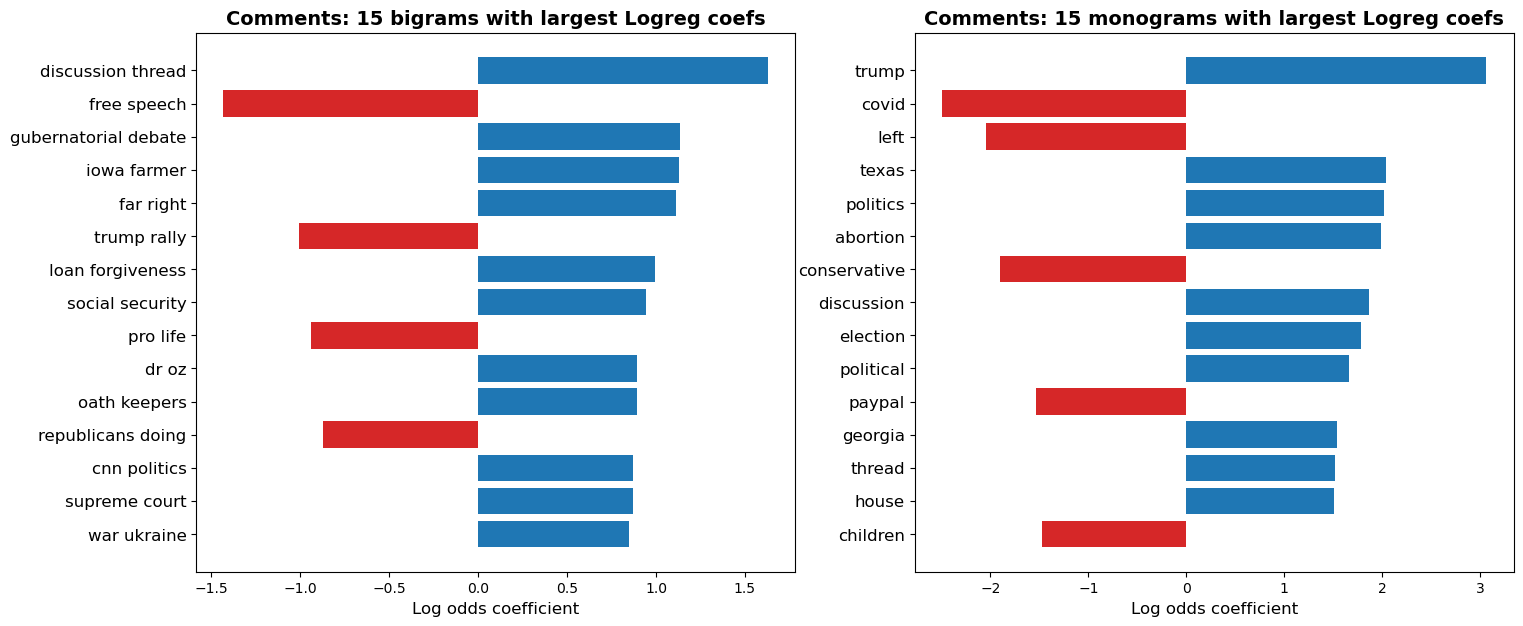

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

make_barplot_lr(ax2, 15, hi_mono_imp, hi_mono_names)
make_barplot_lr(ax1, 15, hi_bi_imp, hi_bi_names)

ax1.set_title('Comments: 15 bigrams with largest Logreg coefs', fontweight='bold', fontsize=14)
ax2.set_title('Comments: 15 monograms with largest Logreg coefs', fontweight='bold', fontsize=14)

plt.show()

The usage of TfidfVectorizer rather than the more simple CountVectorizer does make the interpretation more difficult here. If it were CountVectorizer, we could simply say that one occurence of the word of the n-gram would increase or decrease the odds according to the measured coefficient. But with TfidfVectorizer, the words are weighted by the inverse document frequency. And so what 'an occurence' means becomes a more abstract, normalized thing. Still, these plots do give us some impression of how certain words will swing the odds towards or away from either of the subreddit.

### 1.3) Naive Bayes interpretation

For this algorithm, each feature includes conditional probabilities for each class that the feature is in a given entry of that class. I will divide the e-power of both, to give the relative probability of a given feature being in one class vs the other

In [75]:
nb_in_stack = stacked_model_subs.named_estimators_.m3.named_steps.nb
nb_logprobs = nb_in_stack.feature_log_prob_
nb_relprobs = np.exp(nb_logprobs[1])/np.exp(nb_logprobs[0])
ct3_in_stack = stacked_model_subs.named_estimators_.m3.named_steps.ct
nb_feature_names = ct3_in_stack.get_feature_names_out()

In [76]:
zipped_nbf = zip(nb_feature_names, nb_relprobs)
sorted_nbf = sorted(zipped_nbf, key= lambda x: x[1], reverse=True)

In [77]:
sorted_nbf[:20]

[('ohe__domain_huffpost', 59.402440746856385),
 ('ohe__domain_newrepublic', 48.98095991407456),
 ('ohe__domain_lgbtqnation', 44.81236758096182),
 ('ohe__domain_edition', 42.72807141440548),
 ('ohe__domain_salon', 39.60162716457093),
 ('ohe__domain_commondreams', 39.60162716457092),
 ('ohe__domain_nytimes', 38.142619847981514),
 ('ohe__domain_thedailybeast', 26.7484674708067),
 ('ohe__domain_rollingstone', 24.490479957037277),
 ('ohe__domain_axios', 22.145646769661372),
 ('ohe__domain_independent', 21.885109748841835),
 ('ohe__domain_truthout', 21.88510974884182),
 ('ohe__domain_cnn', 21.506146809467943),
 ('ohe__domain_nbcnews', 18.609787201396117),
 ('ohe__domain_washingtonpost', 18.117343601605334),
 ('ohe__domain_latimes', 17.195443374089997),
 ('ohe__domain_msnbc', 16.67436933245092),
 ('ohe__domain_theatlantic', 14.2426904714685),
 ('ohe__domain_npr', 13.69680338022754),
 ('ohe__domain_theguardian', 13.339495465960736)]

It's no surprise that the 'domain' features weigh very heavily in this model as well.

Now let's make a final bar chart showing the largest relative probabilities for monograms and bigrams:

In [78]:
def add_features(feature, name_mono, imp_mono, name_bi, imp_bi, inv=False):
    if 'tfbg' in feature[0]: 
        if len(feature[0].split(' ')) == 1:
            name_mono.append(feature[0][6:])
            imp_mono.append(feature[1])
        if len(feature[0].split(' ')) == 2:
            name_bi.append(feature[0][6:])
            imp_bi.append(feature[1])
    return

In [79]:
hi_mono_names_p, hi_bi_names_p = [], []
hi_mono_imp_p, hi_bi_imp_p = [], []

hi_mono_names_c, hi_bi_names_c = [], []
hi_mono_imp_c, hi_bi_imp_c = [], []

for i in range(200):
    feature_p = sorted_nbf[i]
    feature_c = sorted_nbf[-(i+1)]
    
    add_features(feature_p, hi_mono_names_p, hi_mono_imp_p,  hi_bi_names_p, hi_bi_imp_p)
    add_features(feature_c, hi_mono_names_c, hi_mono_imp_c,  hi_bi_names_c, hi_bi_imp_c, inv=True)


In [80]:
def make_barplot_nb(ax, wl, val_c, val_p, label_c, label_p):
    yl = np.arange(wl*2)
    clr = ['tab:red'] * wl + ['tab:blue'] * wl

    val_c = [1/x for x in val_c]
    ax.barh(yl, val_c[:wl] + val_p[:wl], color=clr)
    ax.set_yticks(yl)
    ax.set_yticklabels(labels=label_c[:wl] + label_p[:wl], fontsize=12)
    ax.invert_yaxis()
    ax.set_xlabel('Relative odds', fontsize=12)
    return

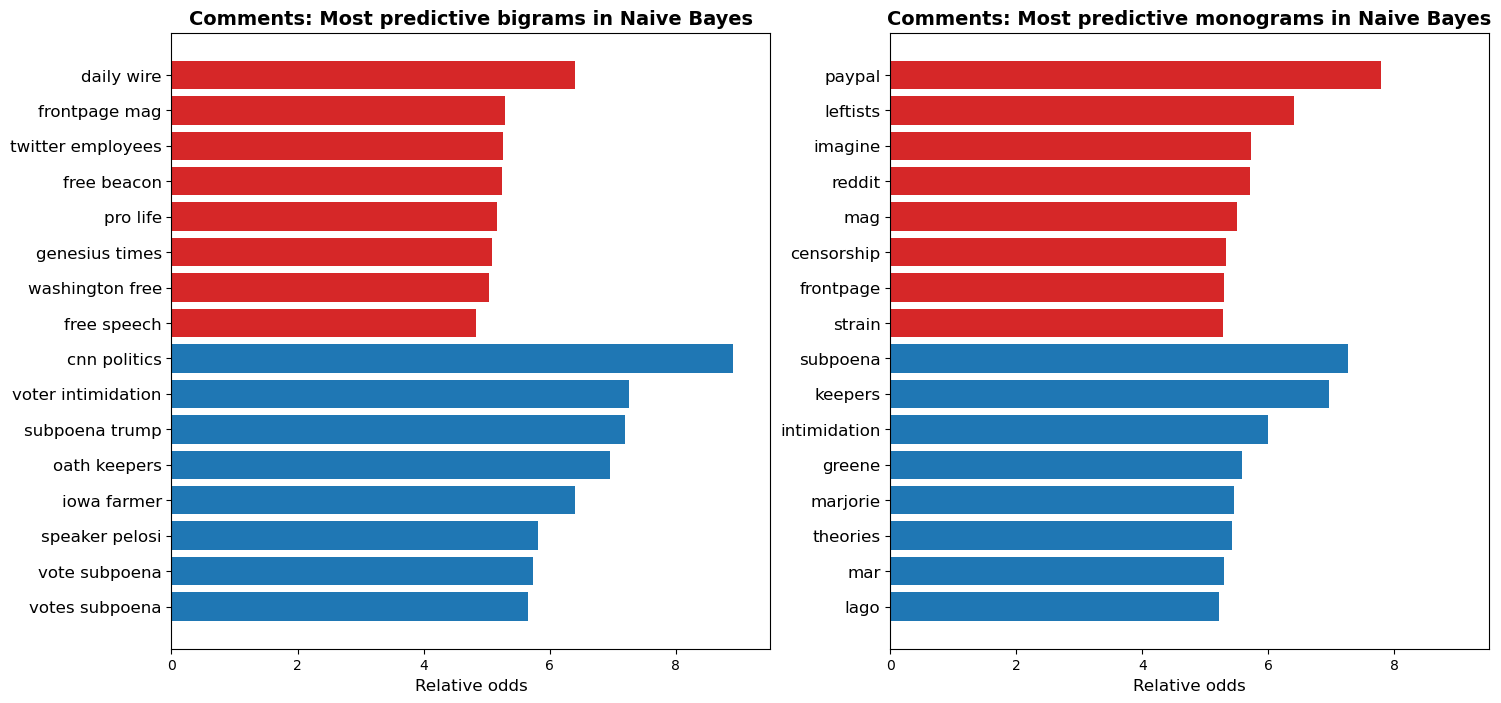

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

make_barplot_nb(ax2, 8, hi_mono_imp_c, hi_mono_imp_p, hi_mono_names_c, hi_mono_names_p)
make_barplot_nb(ax1, 8, hi_bi_imp_c, hi_bi_imp_p, hi_bi_names_c, hi_bi_names_p)

ax1.set_title('Comments: Most predictive bigrams in Naive Bayes', fontweight='bold', fontsize=14)
ax2.set_title('Comments: Most predictive monograms in Naive Bayes', fontweight='bold', fontsize=14)
ax1.set_xlim(0, 9.5)
ax2.set_xlim(0, 9.5)

    
plt.show()

### 1.4) Title model insights: Summary

In the cells above, I've gone over the 3 different individual models that make up the stacking classifier, and tried make some visualizations that can help us interpret the importance of certain features. 

For each of the models, it is clear that he 'domain' features add a lot of predictive power to the model. The 'domain' features specify which website the link comes from (provided it's a link, which it very often is). This makes a lot of sense on an intuitive level, as the mainstream media and conservative media are often very different. The fact that domain names are so predictive reinforces the idea that the two media universes do not mix a lot at all.

In terms words and bi-grams that 

Finally, let's repeat what the accuracy of our model is against the baseline:

In [26]:
y.value_counts(normalize=True)

0    0.526722
1    0.473278
Name: subreddit, dtype: float64

In [27]:
train_acc = stacked_model_subs.score(X_train, y_train)
test_acc = stacked_model_subs.score(X_test, y_test)

In [28]:
print(f'The accuracy on the training data is {round(train_acc, 5)}')
print(f'The accuracy on the test data is {round(test_acc, 5)}')

The accuracy on the training data is 0.99049
The accuracy on the test data is 0.88128


Although the model is overfit, we still end up with a good performance overall. Against a baseline accuracy of 52.6\%, we end up with an accuracy of 88.1\% on the testing data

## 2) Comments model: insights

I will follow a similar procedure as for the title model. Let's start with again loading in the data and the model

In [29]:
com_df = pd.read_csv('../data/all_comments_sentiment.csv')
com_df.set_index('id', inplace=True)
com_df.head()

com_df['subreddit'] = com_df['subreddit'].map({'conservative':0, 'politics':1})

In [30]:
X = com_df[['body', 'score', 'word_length', 'freq_poster', 'sent_label']]
y = com_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
with open('../pickled_models/stacked_model_comments.pkl', 'rb') as pickle_in:
    stacked_model_coms = pickle.load(pickle_in)

In [32]:
stacked_model_coms

StackingClassifier(estimators=[('m1',
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('tfbg',
                                                                                  Tfidf_BigramReducer(bf=0.5,
                                                                                                      max_df=0.99,
                                                                                                      max_features=70000,
                                                                                                      min_df=2,
                                                                                                      preprocessor=<function my_preprocessor at 0x7f8bf3ae6040>,
                                                                                                      stop_words='english'),
                                                                                  'body'),
                                                                                 ('ss',
                                                                                  StandardScaler(),
                                                                                  ['score',
                                                                                   'word_length']),
                                                                                 ('ohe',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=Fal...
                                                 ColumnTransformer(transformers=[('tfbg',
                                                                                  Tfidf_BigramReducer(bf=0.4,
                                                                                                      max_df=0.99,
                                                                                                      max_features=70000,
                                                                                                      min_df=2,
                                                                                                      preprocessor=<function my_preprocessor at 0x7f8bf3ae6040>,
                                                                                                      stop_words='english'),
                                                                                  'body'),
                                                                                 ('ss',
                                                                                  MinMaxScaler(),
                                                                                  ['score',
                                                                                   'word_length']),
                                                                                 ('ohe',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['sent_label'])])),
                                                ('nb', MultinomialNB())]))],
                   final_estimator=LogisticRegression())

How much were each of the models weighed by the final estimator?

In [33]:
models = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
final_coefs = stacked_model_coms.final_estimator_.coef_[0]
for i in range(3):
    print(f'{models[i]} weight: {round(final_coefs[i],3)}')

Logistic Regression weight: 0.004
Random Forest weight: 3.268
Naive Bayes weight: 4.322


It appears that logistic regression did a lot worse, relatively speaking, for the comments. But both Random Forest and Naive Bayes were weighed relatively high, similar to the Titles model

### 2.1) Random Forest interpretation

I can repeat a lot of the steps I took for the titles model

In [95]:
rf_in_stack = stacked_model_coms.named_estimators_.m2.named_steps.rf
rf_importances = rf_in_stack.feature_importances_
ct2_in_stack = stacked_model_coms.named_estimators_.m2.named_steps.ct
rf_feature_names = ct2_in_stack.get_feature_names_out()

In [96]:
zipped_f = zip(rf_feature_names, rf_importances)
sorted_f = sorted(zipped_f, key= lambda x: x[1], reverse=True)[:500]

hi_mono_names, hi_bi_names = [], []
hi_mono_imp, hi_bi_imp = [], []

for feature in sorted_f:
    add_features(feature, hi_mono_names, hi_mono_imp,  hi_bi_names, hi_bi_imp)

In [97]:
#transform the training data again to access tfidf columns
X_tr = ct2_in_stack.fit_transform(X_train)
dir_list_mono = calc_pearson_r_feature(hi_mono_names, X_tr, y_train)
dir_list_bi = calc_pearson_r_feature(hi_bi_names, X_tr, y_train)

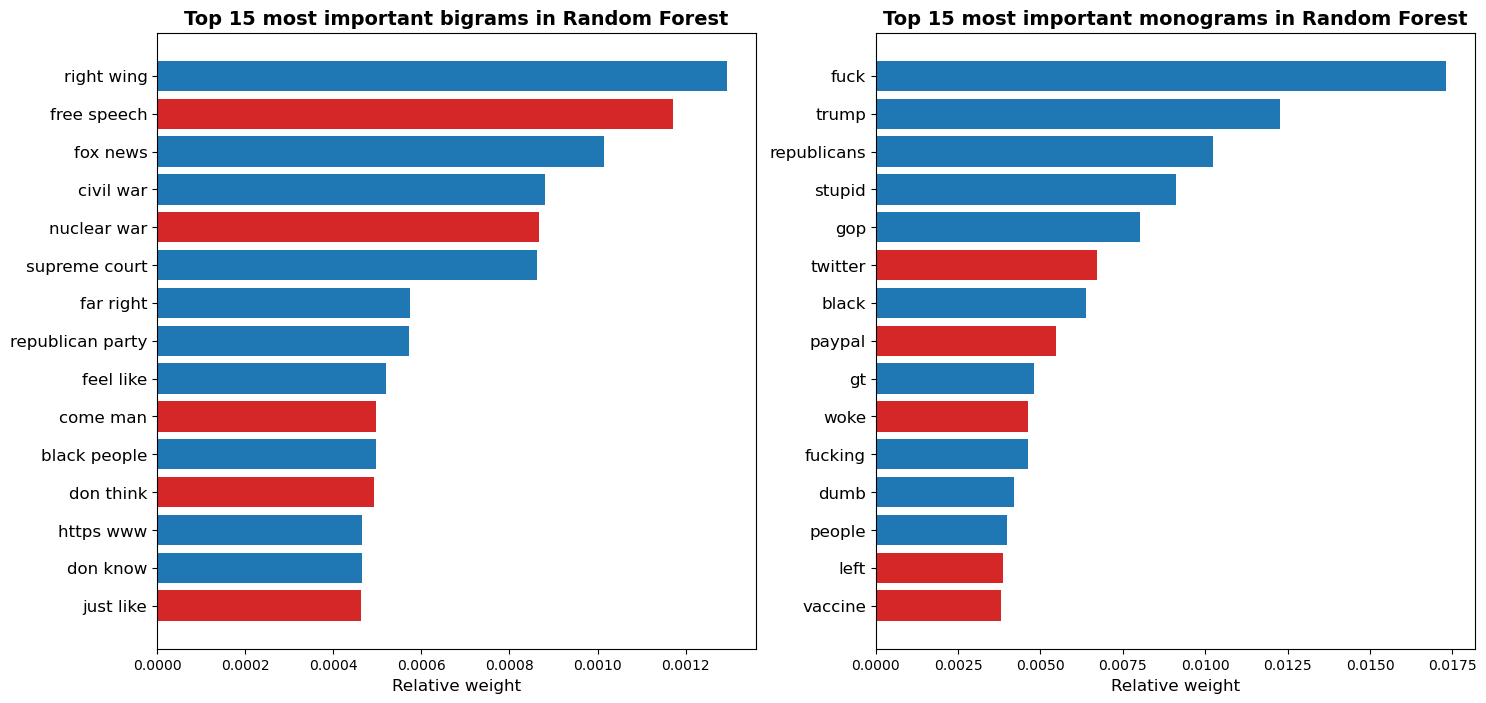

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

make_barplot(ax2, 15, hi_mono_imp, hi_mono_names, dir_list_mono)
make_barplot(ax1, 15, hi_bi_imp, hi_bi_names, dir_list_bi)

ax1.set_title('Top 15 most important bigrams in Random Forest', fontweight='bold', fontsize=14)
ax2.set_title('Top 15 most important monograms in Random Forest', fontweight='bold', fontsize=14)

fig.savefig('../figures/com_rf_features.png', dpi=300)

plt.show()

### 2.2) Logistic Regression Interpretation

In [90]:
lr_in_stack = stacked_model_coms.named_estimators_.m1.named_steps.lr
lr_coefs = lr_in_stack.coef_[0]
ct1_in_stack = stacked_model_coms.named_estimators_.m1.named_steps.ct
lr_feature_names = ct1_in_stack.get_feature_names_out()

In [91]:
zipped_lr = zip(lr_feature_names, lr_coefs)
sorted_lr = sorted(zipped_lr, key= lambda x: np.abs(x[1]), reverse=True)[:500]

In [92]:
sorted_lr[:20]

[('tfbg__fuck', 7.194440177262211),
 ('tfbg__stupid', 5.698732252326108),
 ('tfbg__black', 5.051412569021431),
 ('tfbg__gop', 4.206608095765812),
 ('tfbg__paypal', -4.1524147291260505),
 ('tfbg__republicans', 4.125536176601962),
 ('tfbg__gay', 3.8597314411874954),
 ('tfbg__dumb', 3.700168317576061),
 ('tfbg__leftists', -3.636207733479781),
 ('tfbg__kill', 3.4616101490439424),
 ('tfbg__vaccine', -3.36456406378344),
 ('tfbg__twitter', -3.3407382902521023),
 ('tfbg__woke', -3.2837823947997102),
 ('tfbg__idiots', 2.957987746119257),
 ('tfbg__trump', 2.9561103379044558),
 ('tfbg__shoot', 2.7660691937216044),
 ('tfbg__leftist', -2.6973477837651396),
 ('tfbg__left', -2.612182281524367),
 ('tfbg__idiot', 2.608603575072556),
 ('tfbg__fox', 2.5925701861000223)]

In [93]:
hi_mono_names, hi_bi_names = [], []
hi_mono_imp, hi_bi_imp = [], []

for feature in sorted_lr:
    add_features(feature, hi_mono_names, hi_mono_imp,  hi_bi_names, hi_bi_imp)

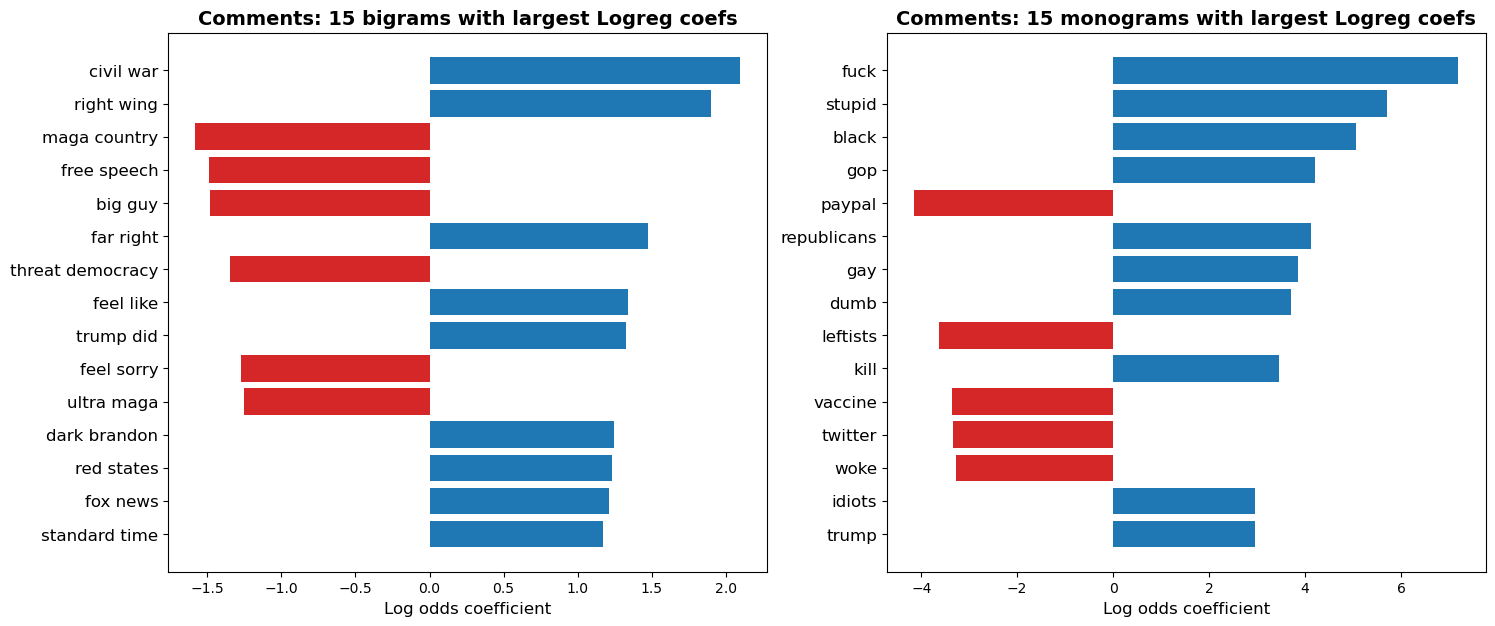

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

make_barplot_lr(ax2, 15, hi_mono_imp, hi_mono_names)
make_barplot_lr(ax1, 15, hi_bi_imp, hi_bi_names)

ax1.set_title('Comments: 15 bigrams with largest Logreg coefs', fontweight='bold', fontsize=14)
ax2.set_title('Comments: 15 monograms with largest Logreg coefs', fontweight='bold', fontsize=14)

fig.savefig('../figures/com_lr_features.png', dpi=300)

plt.show()

### 2.3) Naive Bayes Interpretation

In [138]:
nb_in_stack = stacked_model_coms.named_estimators_.m3.named_steps.nb
nb_logprobs = nb_in_stack.feature_log_prob_
nb_relprobs = np.exp(nb_logprobs[1])/np.exp(nb_logprobs[0])
ct3_in_stack = stacked_model_coms.named_estimators_.m3.named_steps.ct
nb_feature_names = ct3_in_stack.get_feature_names_out()

In [140]:
zipped_nbf = zip(nb_feature_names, nb_relprobs)
sorted_nbf = sorted(zipped_nbf, key= lambda x: x[1], reverse=True)

sorted_nbf[:20]

[('tfbg__fuck', 55.55405982728428),
 ('tfbg__stupid', 34.91181154046277),
 ('tfbg__black', 29.08517105605839),
 ('tfbg__dumb', 18.674172849199763),
 ('tfbg__gay', 18.164836910593635),
 ('tfbg__kill', 15.929714678132157),
 ('tfbg__idiots', 15.856670243789315),
 ('tfbg__shoot', 12.835862591795655),
 ('tfbg__idiot', 12.355145158097114),
 ('tfbg__moron', 10.720278818685056),
 ('tfbg__gerrymandering', 9.313320759157621),
 ('tfbg__civil war', 9.1883409767409),
 ('tfbg__coup', 8.479358606819092),
 ('tfbg__black people', 7.539155248038488),
 ('tfbg__burn', 7.282251682252609),
 ('tfbg__ss', 7.196198256097137),
 ('tfbg__roger', 6.4762589076524),
 ('tfbg__mtg', 6.33043971787534),
 ('tfbg__dumbass', 6.236308692532192),
 ('tfbg__gqp', 6.189542012313564)]

In [141]:
hi_mono_names_p, hi_bi_names_p = [], []
hi_mono_imp_p, hi_bi_imp_p = [], []

hi_mono_names_c, hi_bi_names_c = [], []
hi_mono_imp_c, hi_bi_imp_c = [], []

for i in range(200):
    feature_p = sorted_nbf[i]
    feature_c = sorted_nbf[-(i+1)]
    
    add_features(feature_p, hi_mono_names_p, hi_mono_imp_p,  hi_bi_names_p, hi_bi_imp_p)
    add_features(feature_c, hi_mono_names_c, hi_mono_imp_c,  hi_bi_names_c, hi_bi_imp_c, inv=True)

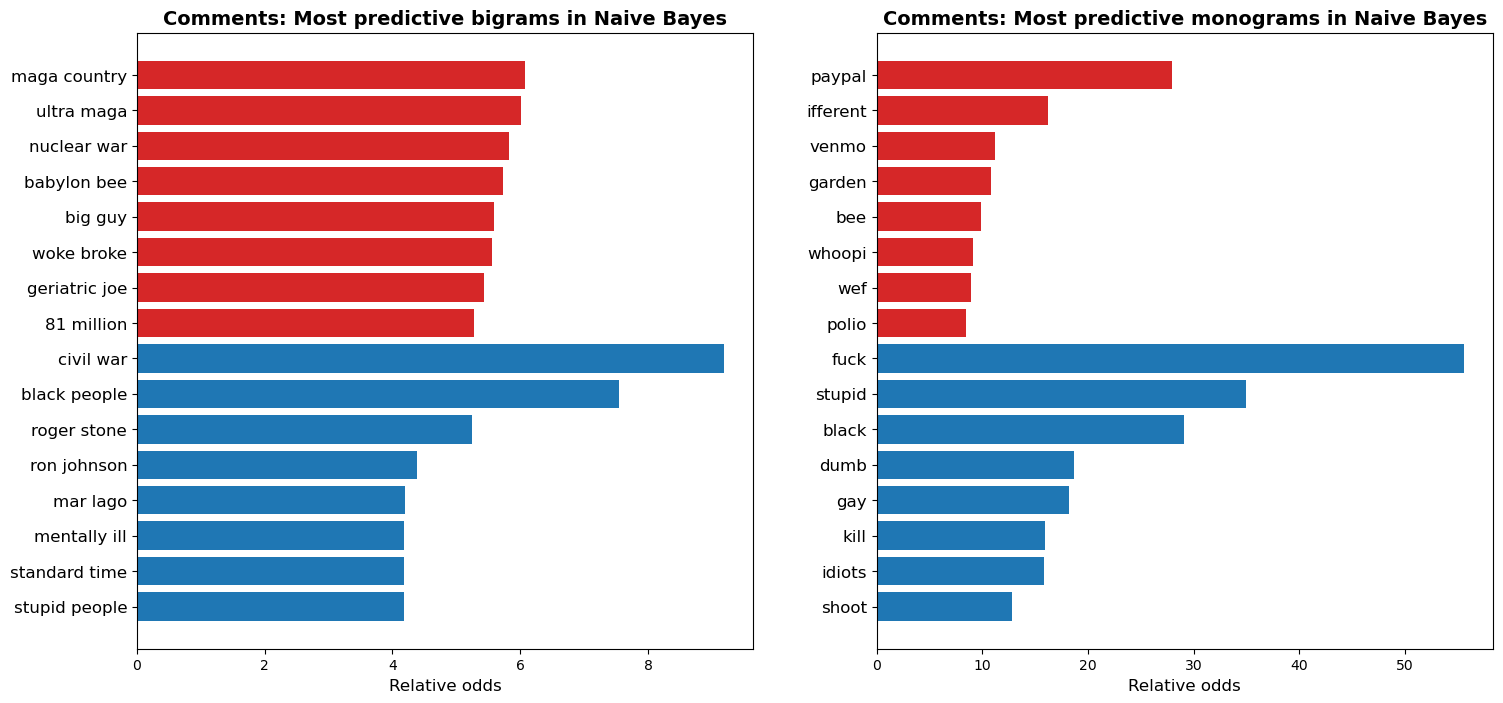

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17.5, 8))

make_barplot_nb(ax2, 8, hi_mono_imp_c, hi_mono_imp_p, hi_mono_names_c, hi_mono_names_p)
make_barplot_nb(ax1, 8, hi_bi_imp_c, hi_bi_imp_p, hi_bi_names_c, hi_bi_names_p)

ax1.set_title('Comments: Most predictive bigrams in Naive Bayes', fontweight='bold', fontsize=14)
ax2.set_title('Comments: Most predictive monograms in Naive Bayes', fontweight='bold', fontsize=14)

fig.savefig('../figures/com_nb_features.png', dpi=300)
plt.show()

### 2.4) Misclassified Comments

Given that the overall classification rate of the model wasn't very good - is there anything we can learn from which comments were missclassified?

In [143]:
preds_test = stacked_model_coms.predict(X_test)

In [144]:
c_idx = np.where(preds_test == y_test)[0]
mc_idx = np.where(preds_test != y_test)[0]

com_class = com_df.iloc[c_idx]
com_mclass = com_df.iloc[mc_idx]

In [145]:
com_class.head()

,parent_id,author,created_utc,body,score,subreddit,word_length,freq_poster,sent_label,sent_score
id,,,,,,,,,,
irhr7g7,4.084409e+10,stickznstonez_,1665212396,https://youtu.be/i1oCQ6bZ_Ws\n\nThis guy might...,1,1,31,0,LABEL_0,0.6696
irhr79r,4.084347e+10,StrillyBings,1665212392,If he was making calls to Georgia for someone ...,1,1,19,0,LABEL_1,0.7425
irhr79a,NaN,After_Ad_9636,1665212391,Duh?\n\nWhy wouldn’t he?,1,1,3,0,LABEL_1,0.5716
irhr720,4.084420e+10,SweetenedTomatoes,1665212386,"Ah, I remember back in my younger days being h...",1,1,47,0,LABEL_2,0.7270
irhr6vk,4.083886e+10,Smart_Interaction_34,1665212381,"Oh they say it, they just get banned.",1,1,8,0,LABEL_0,0.7410


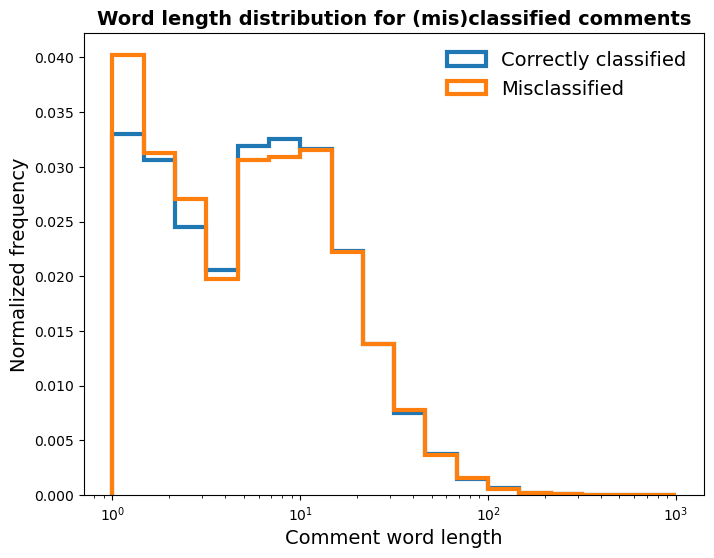

In [150]:
fig, ax = plt.subplots(figsize=(8,6))

logbins = np.logspace(0, 3, 19)
ax.hist(com_class['word_length'], histtype='step', linewidth=3, bins=logbins, density=True, label='Correctly classified')
ax.hist(com_mclass['word_length'], histtype='step', linewidth=3,  bins=logbins, density=True, label='Misclassified')

ax.set_xscale('log')
ax.legend(frameon=False, numpoints=1, fontsize=14)
ax.set_xlabel('Comment word length', fontsize=14)
ax.set_ylabel('Normalized frequency', fontsize=14)
ax.set_title('Word length distribution for (mis)classified comments', fontsize=14, fontweight='bold')
plt.show()

My hunch was that this might be quite an important factor, but it doesn't appear to be all that much. Shorter comments do get misclassified slightly more often, but the different is not as dramatic as one might think. There are plenty of longer comments that get misclassified too.

Can we say something about the vectorized content of the misclassified rows? Let's use the ColumnTransformer in the random forest pipeline

In [156]:
Xtest_transform = ct1_in_stack.transform(X_test)
Xtest_mc = Xtest_transform[mc_idx, :]
Xtest_c = Xtest_transform[c_idx, :]

In [167]:
summed_X_mc = np.sum(Xtest_mc, axis=1)
summed_X_c = np.sum(Xtest_c, axis=1)
np.mean(summed_X_mc), np.mean(summed_X_c)

(3.1769908416928794, 3.669540986977041)

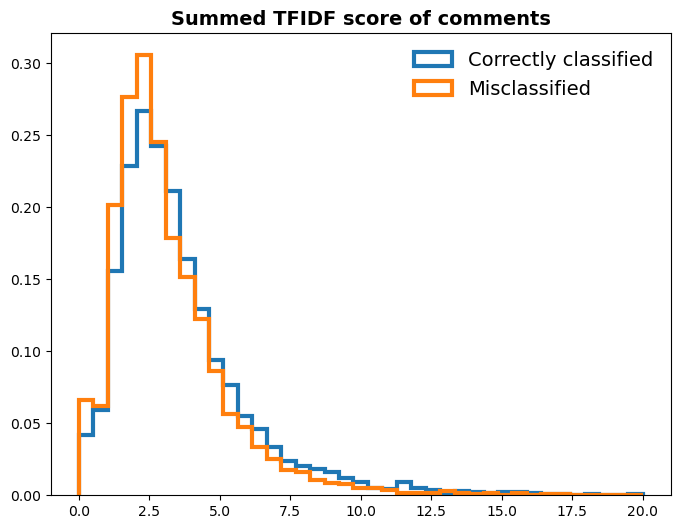

In [176]:
fig, ax = plt.subplots(figsize=(8,6))

linbins = np.linspace(0, 20, 40)
ax.hist(summed_X_c, histtype='step', linewidth=3, bins=linbins, density=True, label='Correctly classified')
ax.hist(summed_X_mc, histtype='step', linewidth=3,  bins=linbins, density=True, label='Misclassified')

ax.legend(frameon=False, numpoints=1, fontsize=14)
#ax.set_yscale('log')
ax.set_title('Summed TFIDF score of comments', fontsize=14, fontweight='bold')
plt.show()

What about the predicted probabilities, using predict_proba? Is it possible that the model is more unsure of misclassified comments (eg. the distribution is closer to 0.5), than for correctly classified comments?

In [225]:
X_c = com_class[['body', 'score', 'word_length', 'freq_poster', 'sent_label']]
X_mc = com_mclass[['body', 'score', 'word_length', 'freq_poster', 'sent_label']]

probs_c = stacked_model_coms.predict_proba(X_c)
probs_mc = stacked_model_coms.predict_proba(X_mc)

Let's get the baseline accuracy again:

In [227]:
y.value_counts(normalize=True)

1    0.539368
0    0.460632
Name: subreddit, dtype: float64

In [228]:
base_conservative = y.value_counts(normalize=True)[0]

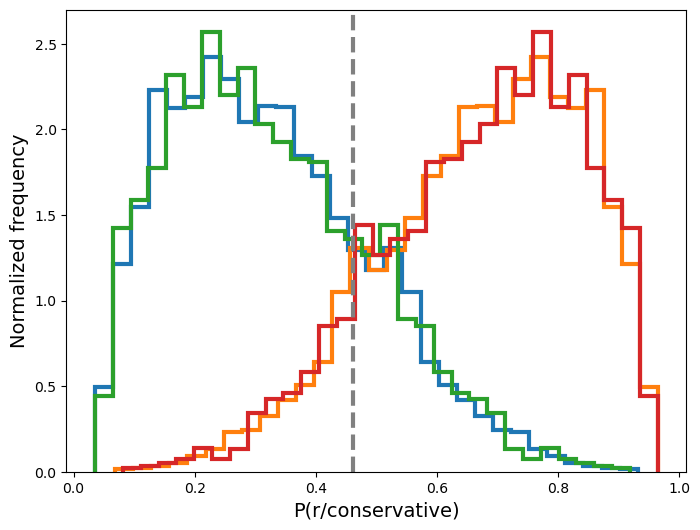

In [234]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(probs_c[:,0], histtype='step', linewidth=3, bins=30, density=True, label='Correctly classified')
ax.hist(probs_c[:,1], histtype='step', linewidth=3, bins=30, density=True, label='Correctly classified')

ax.hist(probs_mc[:,0], histtype='step', linewidth=3,  bins=30, density=True, label='Misclassified')
ax.hist(probs_mc[:,1], histtype='step', linewidth=3, bins=30, density=True, label='Correctly classified')

ax.axvline(base_conservative, color='grey', linewidth=3, linestyle='dashed')
#ax.legend(frameon=False, numpoints=1, fontsize=14)
ax.set_xlabel('P(r/conservative)', fontsize=14)
ax.set_ylabel('Normalized frequency', fontsize=14)
plt.show()

These distributions are again, very similar. But it does suggest something interesting: that the majority of the predicted classes are r/politics, even though the classes are pretty balanced to begin with.

Maybe we should make a Confusion matrix

In [231]:
sum(probs_c[:,1] < 0.47)/probs_c.shape[0]

0.12503186336987

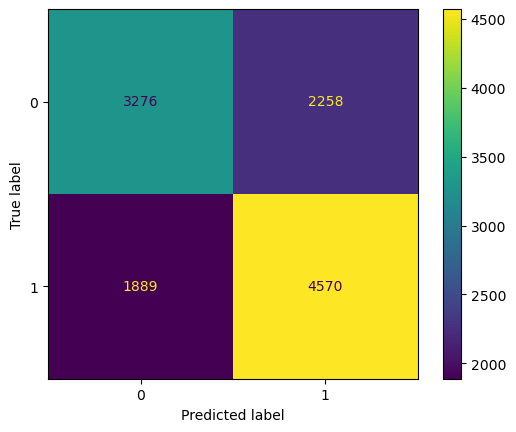

In [207]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_test).ravel()

ConfusionMatrixDisplay.from_predictions(y_test, preds_test)

In [213]:
print( (tn + fp), (tp + fn))
print( (tn + fn), (tp + fp))

print(5534 / (5534 + 6459))
print(5165 / (5534 + 6459))

5534 6459
5165 6828
0.461435837571917
0.430667889602268


In [211]:
/ (5534 + 6459)

0.461435837571917